In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep
from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup file paths / Download query data

In [6]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [7]:
TRAINDIR = os.path.join(os.path.join("..", "queries"), "imdb-unique-plans")
TESTDIR = os.path.join(os.path.join("..", "queries"), "imdb-unique-plans")
RESULTDIR = os.path.join("..", "results")
make_dir(RESULTDIR)

# Query loading helper functions

In [8]:
def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            continue
        template_name = os.path.basename(qdir)
        if sel_templates is not None and template_name not in sel_templates:
            continue
        
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Evaluation helper functions

In [9]:
def get_preds(alg, qreps):
    if isinstance(qreps[0], str):
        # only file paths sent
        qreps = load_qdata(qreps)
    
    ests = alg.test(qreps)
    return ests

def eval_alg(alg, eval_funcs, qreps, samples_type, result_dir="./results/"):
    '''
    '''
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    alg_name = alg.__str__()
    exp_name = alg.get_exp_name()
    
    if isinstance(qreps[0], str):
        # only file paths sent
        qreps = load_qdata(qreps)
    
    ests = alg.test(qreps)

    for efunc in eval_funcs:
        rdir = None
        if result_dir is not None:
            rdir = os.path.join(result_dir, exp_name)
            make_dir(rdir)

        errors = efunc.eval(qreps, ests, samples_type=samples_type,
                result_dir=rdir,
                num_processes = -1,
                alg_name = alg_name,
                use_wandb=0)

        print("{}, {}, #samples: {}, {}: mean: {}, median: {}, 99p: {}"\
                .format(samples_type, alg, len(errors),
                    efunc.__str__(),
                    np.round(np.mean(errors),3),
                    np.round(np.median(errors),3),
                    np.round(np.percentile(errors,99),3)))

# Load queries

In [10]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.8, sel_templates=["2b"])
val_qfns = []
test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0, sel_templates=["2a"])

print("Selected {} training queries, {} validation queries, {} test queries".\
      format(len(train_qfns), len(val_qfns), len(test_qfns)))

Selected 227 training queries, 0 validation queries, 388 test queries


In [11]:
from evaluation.eval_fns import QError, SimplePlanCost
EVAL_FNS = []
EVAL_FNS.append(QError())
EVAL_FNS.append(SimplePlanCost())

In [12]:
def init_featurizer(featurization_type):
    # Load database specific data, e.g., information about columns, tables etc.
    dbdata_fn = os.path.join(TRAINDIR, "dbdata.json")
    featurizer = Featurizer(None, None, None, None, None)
    
    with open(dbdata_fn, "r") as f:
        dbdata = json.load(f)
        
    featurizer.update_using_saved_stats(dbdata)
    
    featurizer.setup(ynormalization="log",
        feat_separate_alias = 0,
        onehot_dropout = onehot_dropout,
        feat_mcvs = 0,
        heuristic_features = 1,
        featurization_type=featurization_type,
        table_features=1,
        flow_features = 0,
        join_features= "onehot",
        set_column_feature= "onehot",
        max_discrete_featurizing_buckets=10,
        max_like_featurizing_buckets=10,
        embedding_fn = "none",
        embedding_pooling = None,
        implied_pred_features = 0,
        feat_onlyseen_preds = 1)
    featurizer.update_ystats(trainqs)
    
    featurizer.update_max_sets(trainqs)
    featurizer.update_workload_stats(trainqs)
    featurizer.init_feature_mapping()
    #featurizer.update_ystats(trainqs)
   

    # if feat_onlyseen_preds:
    # just do it always
    featurizer.update_seen_preds(trainqs)
    
    return featurizer

In [13]:
# going to start training the models
trainqs = load_qdata(train_qfns)

In [14]:
testqs = load_qdata(test_qfns)

In [15]:
max_epochs = 30
lr=0.0001
training_opt = "none"
opt_lr = 0.1
swa_start = 5
mask_unseen_subplans = 0
subplan_level_outputs=0
normalize_flow_loss = 1
heuristic_unseen_preds = 0
cost_model = "C"
use_wandb = 0
eval_fns = "qerr,plancost"
load_padded_mscn_feats = 1
mb_size = 1024
weight_decay = 0.0
load_query_together = 0
result_dir = "./results"

onehot_dropout=0
onehot_mask_truep=0.8
onehot_reg=0
onehot_reg_decay=0.1
eval_epoch = 200
optimizer_name="adamw"
clip_gradient=20.0
loss_func_name = "mse"
hidden_layer_size = 128
num_hidden_layers = 2

In [16]:
#from cardinality_estimation.mscn import MSCN as MSCN2
from cardinality_estimation.mscn import MSCNCaptum as MSCN2

featurizer = init_featurizer("set")

mscn = MSCN2(max_epochs = max_epochs, lr=lr,
                training_opt = training_opt,
                inp_dropout = 0.0,
                hl_dropout = 0.0,
                comb_dropout = 0.0,
                max_num_tables = -1,
                opt_lr = opt_lr,
                swa_start = swa_start,
                mask_unseen_subplans = mask_unseen_subplans,
                subplan_level_outputs=subplan_level_outputs,
                normalize_flow_loss = normalize_flow_loss,
                heuristic_unseen_preds = heuristic_unseen_preds,
                cost_model = cost_model,
                use_wandb = use_wandb,
                eval_fns = eval_fns,
                load_padded_mscn_feats = load_padded_mscn_feats,
                mb_size = mb_size,
                weight_decay = weight_decay,
                load_query_together = load_query_together,
                result_dir = result_dir,
                onehot_dropout=onehot_dropout,
                onehot_mask_truep=onehot_mask_truep,
                onehot_reg=onehot_reg,
                onehot_reg_decay=onehot_reg_decay,
                # num_hidden_layers=num_hidden_layers,
                eval_epoch = eval_epoch,
                optimizer_name=optimizer_name,
                clip_gradient=clip_gradient,
                loss_func_name = loss_func_name,
                hidden_layer_size = hidden_layer_size,
                other_hid_units = hidden_layer_size,
                num_hidden_layers = 2,
                early_stopping = False,
                random_bitmap_idx = False,
                reg_loss = False,
                )

Updated stats to remove alias based columns
min y: 0.0, max y: 20.436771454911057
Max tables:  11 Max pred vals:  56 Max joins:  11
max pred vals: 56
Seen comparison operators:  {'lt', 'in'}
Tables:  {'role_type', 'movie_info', 'cast_info', 'kind_type', 'name', 'title', 'movie_keyword', 'keyword', 'info_type'}
new alias:  cn
new alias:  cn
new alias:  ct
new alias:  mii
new alias:  pi


In [17]:
mscn.train(trainqs, valqs=None, testqs=None,
    featurizer=featurizer, result_dir=RESULTDIR)

load mscn feats False
Extracting features took:  46.006089210510254
SetConvCaptum(
  (inp_drop_layer): Dropout(p=0.0, inplace=False)
  (hl_drop_layer): Dropout(p=0.0, inplace=False)
  (combined_drop_layer): Dropout(p=0.0, inplace=False)
  (sample_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (sample_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (predicate_mlp1): Linear(in_features=44, out_features=128, bias=True)
  (predicate_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (join_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (join_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (out_mlp1): Linear(in_features=384, out_features=128, bias=True)
  (out_mlp2): Linear(in_features=128, out_features=1, bias=True)
)
Training samples: 65830, Model size: 0.42906
Epoch 0 took 3.34, Avg Loss: 0.039549, #samples: 65830
Epoch 1 took 3.3, Avg Loss: 0.033309, #samples: 65830
Epoch 2 took 3.32, Avg Loss: 0.021967, #samples: 65830
Epo

In [21]:
#evaluate model
eval_alg(mscn, EVAL_FNS, trainqs, "train")

#preds = mscn.test(testqs)
eval_alg(mscn, EVAL_FNS, testqs, "test")

load mscn feats False
Extracting features took:  0.19625163078308105
samples: 290, _eval_ds took: 0.011362075805664062
train, MSCNCaptum, #samples: 290, QError: mean: 5.845, median: 2.952, 99p: 27.338
train, #samples: 1, plancost relative: 1.004
train, MSCNCaptum, #samples: 1, SimplePlanCost: mean: 1323170.571, median: 1323170.571, 99p: 1323170.571
load mscn feats False
Extracting features took:  77.30346155166626
samples: 112520, _eval_ds took: 2.3096530437469482
test, MSCNCaptum, #samples: 112520, QError: mean: 608.036, median: 3.02, 99p: 857.041
test, #samples: 388, plancost relative: 2.803
test, MSCNCaptum, #samples: 388, SimplePlanCost: mean: 8361410.689, median: 1438256.882, 99p: 104474937.816


In [ ]:
#eval_alg(mscn, EVAL_FNS, testqs, "test")

In [23]:
models_path = "results/" + mscn.get_exp_name() + "/"
print(models_path)

results/MSCNCaptum2633363450/


In [24]:
# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation, Lime

In [25]:
#featurizer = init_featurizer("set")
ds = QueryDataset(trainqs[0:10], featurizer,
        True,
        load_padded_mscn_feats=True)
loader = data.DataLoader(ds,
        batch_size=1, shuffle=False,
        collate_fn=mscn_collate_fn_together,
        )

testds = QueryDataset(testqs[0:3], featurizer,
        True,
        load_padded_mscn_feats=True)

testloader = data.DataLoader(testds,
        batch_size=1, shuffle=False,
        collate_fn=mscn_collate_fn_together,
        )

load mscn feats False
Extracting features took:  0.19812822341918945
load mscn feats False
Extracting features took:  0.5879278182983398


In [26]:
iloader = iter(testloader)

In [27]:
xbatch,y,info = next(iloader)
print(torch.sum(xbatch["pred"][:,:,20]))
print(torch.sum(xbatch["pred"][:,:,21]))

tensor(213.6691)
tensor(532.2302)


In [28]:
import sqlparse
sql = testqs[0]["sql"]
print(sqlparse.format(sql, reindent=True, keyword_case='upper'))

SELECT COUNT(*)
FROM title AS t,
     kind_type AS kt,
     info_type AS it1,
     movie_info AS mi1,
     movie_info AS mi2,
     info_type AS it2,
     cast_info AS ci,
     role_type AS rt,
     name AS n,
     movie_keyword AS mk,
     keyword AS k
WHERE t.id = ci.movie_id
  AND t.id = mi1.movie_id
  AND t.id = mi2.movie_id
  AND t.id = mk.movie_id
  AND k.id = mk.keyword_id
  AND mi1.movie_id = mi2.movie_id
  AND mi1.info_type_id = it1.id
  AND mi2.info_type_id = it2.id
  AND (it1.id in ('5'))
  AND (it2.id in ('8'))
  AND t.kind_id = kt.id
  AND ci.person_id = n.id
  AND ci.role_id = rt.id
  AND (mi1.info in ('Argentina:13',
                    'Australia:M',
                    'Australia:R',
                    'Hong Kong:IIB',
                    'Italy:T',
                    'Malaysia:U',
                    'Peru:14',
                    'Portugal:M/12'))
  AND (mi2.info in ('Argentina',
                    'Germany',
                    'Hong Kong',
                    'Po

In [29]:
print(featurizer.featurizer_type_idxs["col_onehot"])
print(featurizer.columns_onehot_idx)
# mii.info
# n.name
# n.name_pcode_cf
# n.surname_pcode
#[0  1  6  8  9 11 17 18 20 21 34 37 38 39 40 41 42 43 44 45]

(2, 18)
{'ci.note': 0, 'it.id': 1, 'k.keyword': 2, 'kt.kind': 3, 'mi.info': 4, 'n.gender': 5, 'n.name': 6, 'n.name_pcode_cf': 7, 'n.name_pcode_nf': 8, 'n.surname_pcode': 9, 'rt.role': 10, 't.production_year': 11, 't.title': 12}


In [30]:
curx = xbatch["pred"].detach().numpy()
print(curx.shape)
xsum = curx.sum(axis=0).sum(axis=0)

print(xsum.shape)
print(xsum)

(290, 11, 44)
(44,)
[918.000 540.000 0.000 188.000 0.000 136.000 372.000 111.000 0.000 0.000
 0.000 0.000 111.000 540.000 0.000 0.000 0.000 0.000 0.000 0.000 213.669
 532.230 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 297.000 186.000 186.000 94.000 322.000 297.000 280.000 186.000 322.000
 297.000 637.010 707.557]


In [31]:
def get_attr_vecs(curx, curattrs):
    #idxs = 0
    xsum = curx.sum(axis=0).sum(axis=0)
    zero_idxs = xsum == 0
    curattrs = curattrs[:,:,~zero_idxs]
    idxs = np.array(range(len(xsum)))[~zero_idxs]
    
    #print(curx)
    #print(zero_idxs)
    #print(idxs)
    
    curx = curx[:,:,~zero_idxs]
    
    assert curx.shape == curattrs.shape
    
    # TODO: avg based on non-zero elements
    
    #print("attr sum: ", np.sum(curattrs))
    curattrs = np.abs(curattrs)
    #print("attr sum after abs: ", np.sum(curattrs))
    
    attr_sum = curattrs.sum(axis=0).sum(axis=0)
    
    assert attr_sum.shape[0] == curx.shape[-1]
    
    # TODO: do we need this?
    #attr_sum = attr_sum / np.linalg.norm(attr_sum, ord=1)
    
    # TODO: do this or no?
    curx_nonz = curx != 0
    
    xnonzero_sums = curx_nonz.sum(axis=0).sum(axis=0)
    
    #TODO?
    attr_sum = attr_sum / xnonzero_sums
    
    return idxs, attr_sum

def get_mscn_attrs(xbatch, attrs, featurizer, normalize=True):
    '''
    returns a vector with x-axis names and attribution values;
    '''
    batchsize = xbatch["table"].shape[0]
    assert batchsize == attrs[0].shape[0]
    tabidxs, tabattrs = get_attr_vecs(xbatch["table"].detach().numpy(), attrs[0].detach().numpy())
    predidxs, predattrs = get_attr_vecs(xbatch["pred"].detach().numpy(), attrs[1].detach().numpy())
    print(predidxs)
    joinidxs, joinattrs = get_attr_vecs(xbatch["join"].detach().numpy(), attrs[2].detach().numpy())
    
    # TODO: need to do sample_bitmaps
    tablabels = []
    for curtabidx in tabidxs:
        for tab,tidx in featurizer.table_featurizer.items():
            if tidx == curtabidx:
                tablabels.append(tab)
                break
    joinlabels = []
    for curjidx in joinidxs:
        for join,jidx in featurizer.join_featurizer.items():
            found = False
            if curjidx == jidx:
                joinlabels.append(join)
                found = True
                break
        if not found:
            joinlabels.append("unknown")
    # TODO: join-stats
    
    predlabels = []
    colstart,collen = featurizer.featurizer_type_idxs["col_onehot"]
    # TODO: if stats used
    #colstatsstart,colstatsend = self.featurizer_type_idxs["col_stats"]
    cmp_start,cmplen = featurizer.featurizer_type_idxs["cmp_op"]
    cstart,clen = featurizer.featurizer_type_idxs["constant_continuous"]
    lstart,llen = featurizer.featurizer_type_idxs["constant_like"]
    dstart,dlen = featurizer.featurizer_type_idxs["constant_discrete"]
    hstart,hlen = featurizer.featurizer_type_idxs["heuristic_ests"]
    
    #print(hstart, hlen)
    for pi in predidxs:
        if pi >= colstart and pi < colstart+collen:
            found = False
            for col,colidx in featurizer.columns_onehot_idx.items():
                if colidx == pi-colstart:
                #if colidx == pi:
                    print(col)
                    predlabels.append(col)
                    found = True
                    break     
            if not found:
                print(pi)
                predlabels.append("col-unknown")
        elif pi >= cmp_start and pi < cmp_start+cmplen:
            predlabels.append("cmp")
        elif pi == cstart:
            #predlabels.append("<")
            predlabels.append("range-filter")
        elif pi == cstart+1:
            predlabels.append("range-filter")
        elif pi >= lstart and pi < lstart+llen:
            #predlabels.append("Like-Hash-" + str(pi))
            predlabels.append("Like-Hashes")
        elif pi >= dstart and pi < dstart+dlen:
            #predlabels.append("Constant-Hash-" + str(pi))
            predlabels.append("Constant-Hashes")
        elif pi == hstart:
            predlabels.append("PostgreSQL Est (Table)")
        elif pi == hstart+1:
            predlabels.append("PostgreSQL Est (Subplan)")
    
    assert len(predidxs) == len(predlabels)
#     print(len(predidxs), len(predlabels))
#     print(predidxs)
#     print(predlabels)
    attrs = np.concatenate([tabattrs, joinattrs, predattrs])
    xlabels = tablabels + joinlabels + predlabels
    
    if normalize:
        attrs = attrs / np.linalg.norm(attrs, ord=1)
    
    return xlabels,attrs

In [32]:
from cardinality_estimation.nets import *

def get_model_attrs(mscn_model, weights, xbatch):
    n_out = 1
    sfeats = mscn_model.sample_mlp1.in_features
    pfeats = mscn_model.predicate_mlp1.in_features
    jfeats = mscn_model.join_mlp1.in_features

    net = SetConvNoFlow(sfeats,
        pfeats, jfeats,
        128,
        n_out=n_out,
        dropouts=[0.0, 0.0, 0.0])
    net.load_state_dict(weights)
    
    model = net
    model.eval()
    ig = IntegratedGradients(model)
    #ig_nt = NoiseTunnel(ig)
    #dl = DeepLift(model)
    #gs = GradientShap(model)
    #fa = FeatureAblation(model)
    #limea = Lime(model)
    ig_attr_test = ig.attribute(tuple([xbatch["table"], xbatch["pred"],
                            xbatch["join"], 
                            xbatch["tmask"], xbatch["pmask"], 
                                   xbatch["jmask"]]), n_steps=50)
    #print("ig done")
    
    xlabels, igattrs = get_mscn_attrs(xbatch, ig_attr_test, featurizer, normalize=False)

    return xlabels, igattrs

In [33]:
weights = mscn.net.state_dict()
xlabels,attrs = get_model_attrs(mscn.net, weights, xbatch)

[ 0  1  3  5  6  7 12 13 20 21 32 33 34 35 36 37 38 39 40 41 42 43]
it.id
kt.kind
mi.info
n.gender
rt.role
t.production_year


In [34]:
attrs

array([0.123, 0.073, 0.071, 0.081, 0.026, 0.072, 0.036, 0.078, 0.076,
       0.021, 0.054, 0.022, 0.062, 0.011, 0.087, 0.008, 0.003, 0.031,
       0.026, 0.060, 0.051, 0.078, 0.014, 0.012, 0.013, 0.037, 0.029,
       0.020, 0.016, 0.007, 0.019, 0.015, 0.013, 0.023, 0.027, 0.002,
       0.019, 0.011, 0.026, 0.054])

In [35]:
mscn.net

SetConvCaptum(
  (inp_drop_layer): Dropout(p=0.0, inplace=False)
  (hl_drop_layer): Dropout(p=0.0, inplace=False)
  (combined_drop_layer): Dropout(p=0.0, inplace=False)
  (sample_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (sample_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (predicate_mlp1): Linear(in_features=44, out_features=128, bias=True)
  (predicate_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (join_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (join_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (out_mlp1): Linear(in_features=384, out_features=128, bias=True)
  (out_mlp2): Linear(in_features=128, out_features=1, bias=True)
)

In [37]:
import seaborn as sns

def plot_attrs(xlabels, attrs, ax=None):
    if ax is None:
        plt.figure(figsize=(20, 20))
        ax = plt.axes()

    #plt.yticks(fontsize=20)
    sns.barplot(x=attrs, y=xlabels, color='#4260f5', orient="horizontal", ax=ax, ci=None)

In [38]:
# import pickle

# if onehot_dropout:
#     with open("dropout-attrs.pkl", "wb") as f:
#         pickle.dump([xlabels, attrs], f)
# else:
#     with open("default-attrs.pkl", "wb") as f:
#         pickle.dump([xlabels, attrs], f)

/tmp/ipykernel_6421/1505415145.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=attrs, y=xlabels, color='#4260f5', orient="horizontal", ax=ax, ci=None)


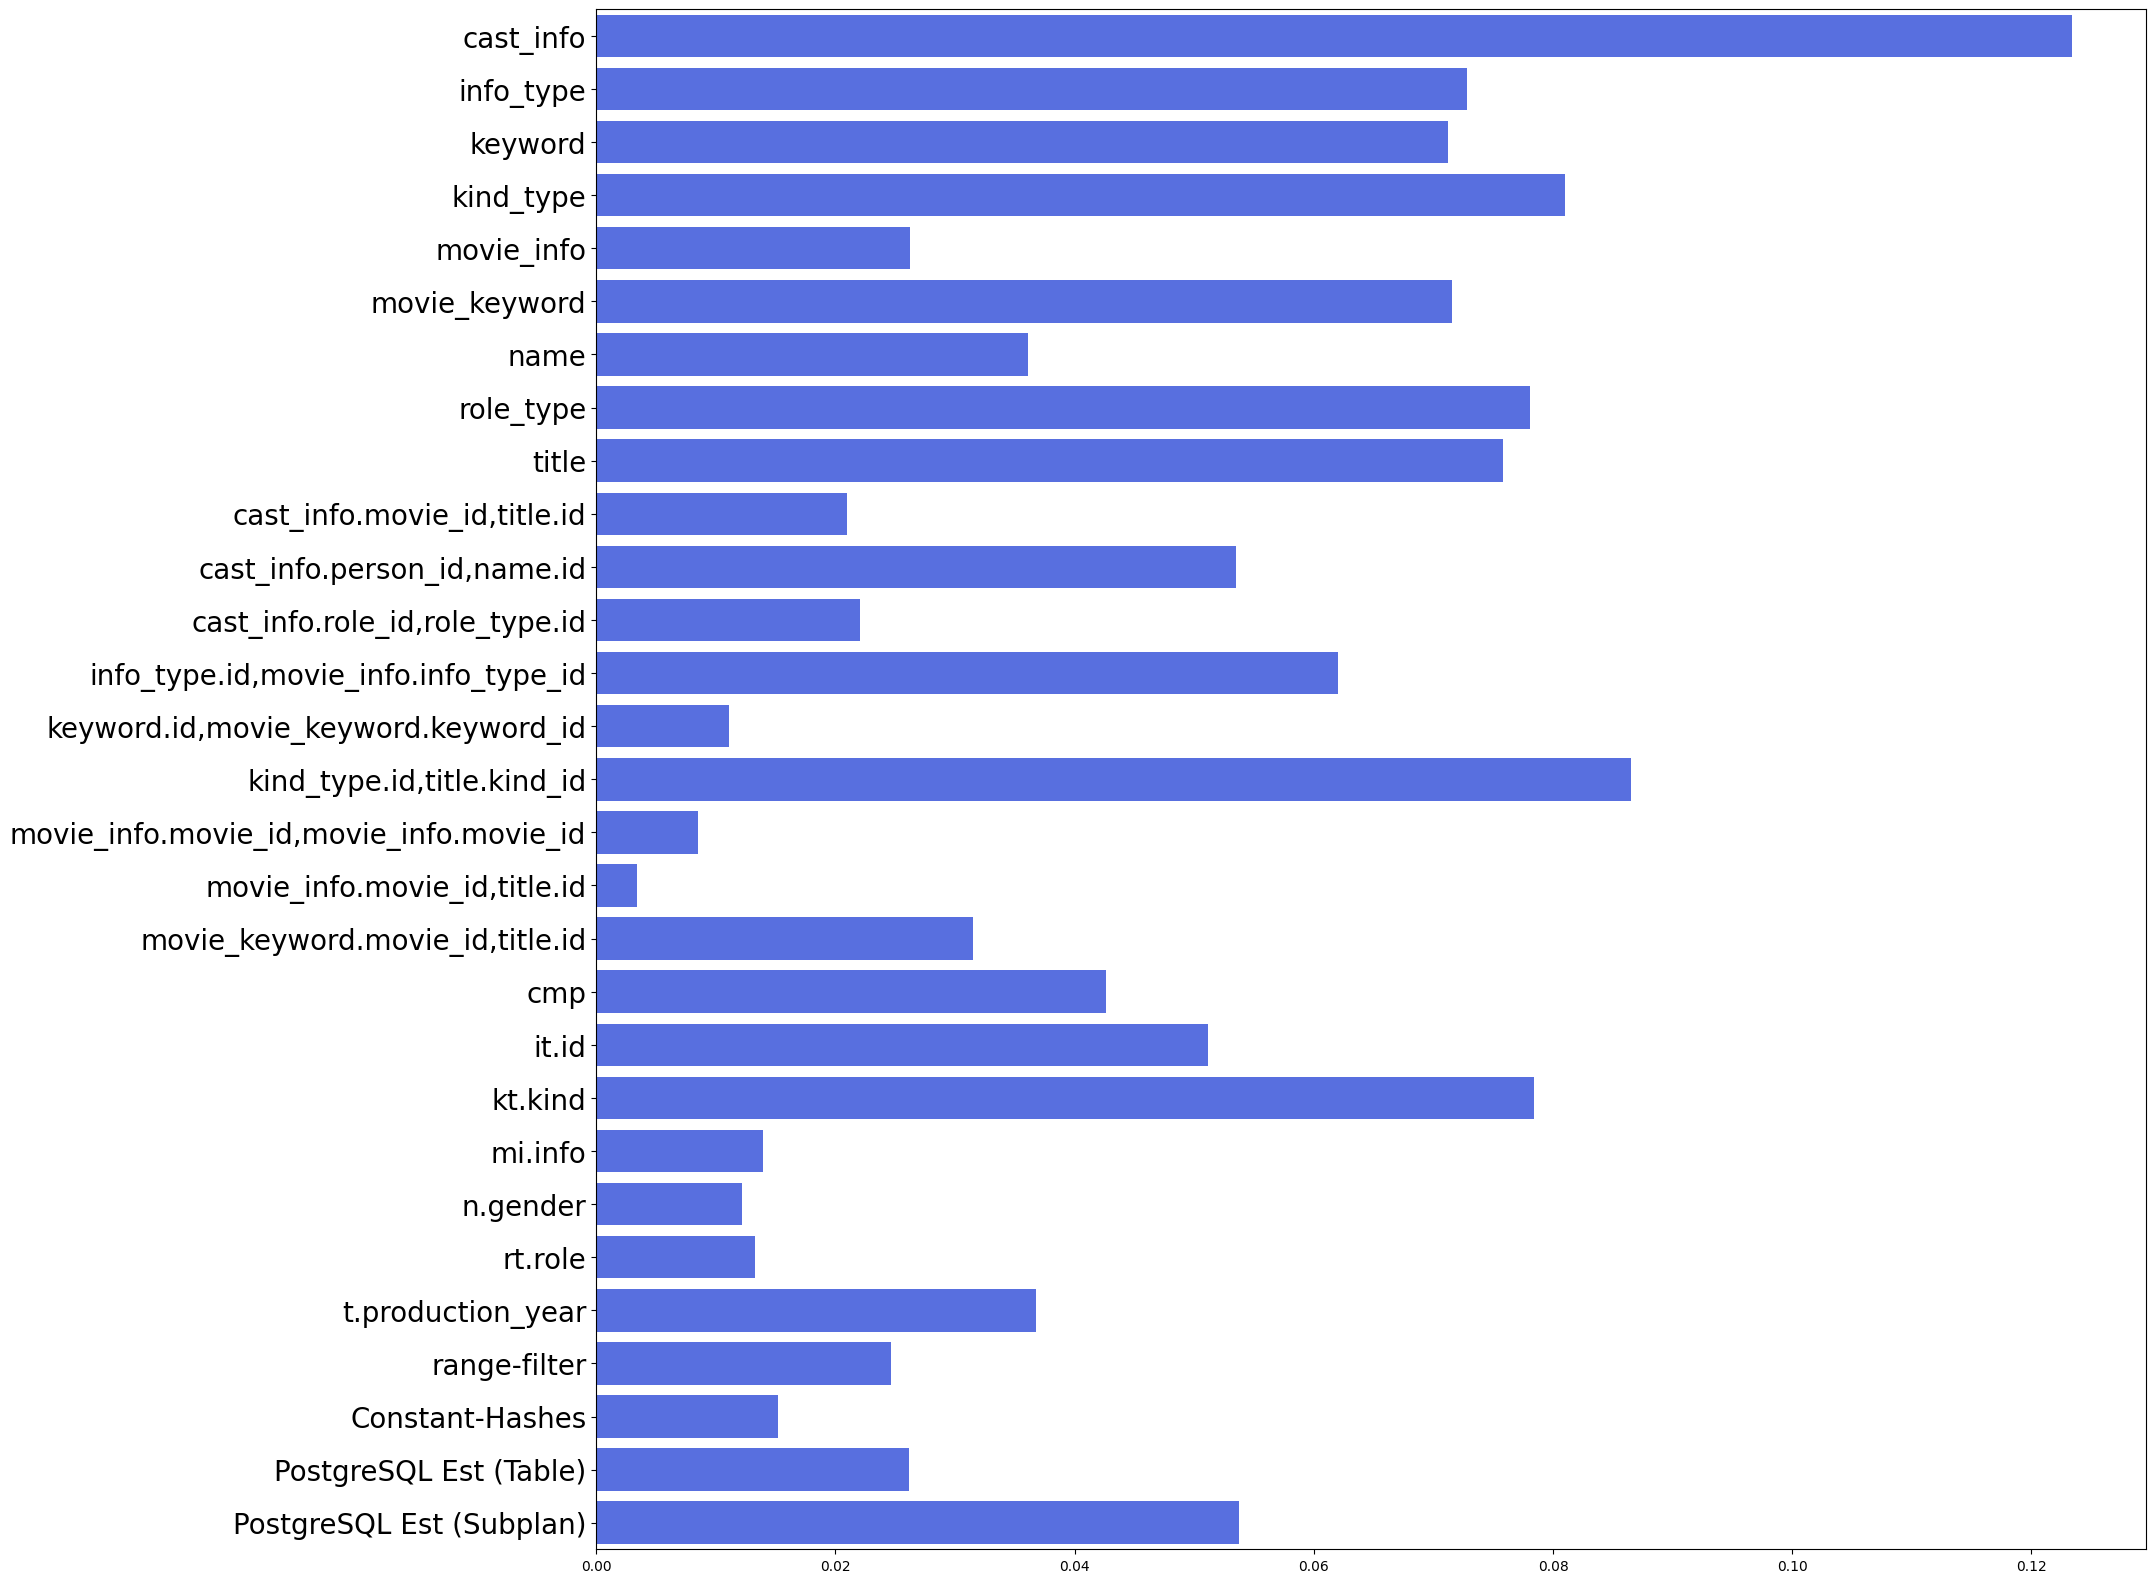

In [39]:
plot_attrs(xlabels, attrs)
plt.yticks(fontsize=20)
#plt.show()
plt.savefig("attribution-dropout.png")

In [41]:
featurizer.featurizer_type_idxs

{'join_onehot': (0, 9),
 'cmp_op': (0, 2),
 'col_onehot': (2, 18),
 'constant_continuous': (20, 2),
 'constant_like': (22, 10),
 'constant_discrete': (32, 10),
 'heuristic_ests': (42, 2)}

In [42]:
print(xbatch["table"].sum(axis=[0,1]))
print(xbatch["pred"].sum(axis=[0,1]))
print(xbatch["join"].sum(axis=[0,1]))

print(xbatch["table"].shape)
print(xbatch["pred"].shape)
print(xbatch["join"].shape)

tensor([220., 188.,  92., 136., 372., 182., 111., 111., 270.])
tensor([918.0000, 540.0000,   0.0000, 188.0000,   0.0000, 136.0000, 372.0000,
        111.0000,   0.0000,   0.0000,   0.0000,   0.0000, 111.0000, 540.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 213.6690,
        532.2302,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000, 297.0000, 186.0000, 186.0000,
         94.0000, 322.0000, 297.0000, 280.0000, 186.0000, 322.0000, 297.0000,
        637.0089, 707.5573])
tensor([216., 110., 110., 155.,  91., 135., 124., 240., 180.])
torch.Size([290, 11, 9])
torch.Size([290, 11, 44])
torch.Size([290, 11, 9])


In [43]:
def get_attr_vecs_single(curx, curattrs):
    #idxs = 0
    #print(curx.shape)
    #print(curattrs.shape)
    xsum = curx.sum(axis=0).sum(axis=0)
    #print(xsum.shape)
    zero_idxs = xsum == 0
    curattrs = curattrs[:,:,~zero_idxs]
    idxs = np.array(range(len(xsum)))[~zero_idxs]
    
    curx = curx[:,:,~zero_idxs]
    
    assert curx.shape == curattrs.shape
    
    # TODO: abs values or also accept negative correlations?
    curattrs = np.abs(curattrs)
    #print(curattrs)
    
    attr_sum = curattrs.sum(axis=0).sum(axis=0)
    
    assert attr_sum.shape[0] == curx.shape[-1]
    
    # TODO: do we need this?
    #attr_sum = attr_sum / np.linalg.norm(attr_sum, ord=1)
    
    # TODO: do this or no?
    curx_nonz = curx != 0
    
    xnonzero_sums = curx_nonz.sum(axis=0).sum(axis=0)
    
#     print(attr_sum)
#     print(xnonzero_sums)
    # Do this because different features have different number of copies in the same set, 
    # e.g, subplan features are in every vector
    attr_sum = attr_sum / xnonzero_sums
    
    return idxs, attr_sum

def get_mscn_attrs_single(xbatch, xi, attrs, featurizer, normalize=True):
    '''
    returns a vector with x-axis names and attribution values;
    '''
    #batchsize = xbatch["table"].shape[0]
    #assert batchsize == attrs[0].shape[0]
    tabidxs, tabattrs = get_attr_vecs_single(xbatch["table"][xi:xi+1].detach().numpy(), 
                                      attrs[0].detach().numpy())
    predidxs, predattrs = get_attr_vecs_single(xbatch["pred"][xi:xi+1].detach().numpy(), 
                                        attrs[1].detach().numpy())
    #print(predidxs)
    joinidxs, joinattrs = get_attr_vecs_single(xbatch["join"][xi:xi+1].detach().numpy(), 
                                        attrs[2].detach().numpy())
    
    # TODO: need to do sample_bitmaps
    tablabels = []
    for curtabidx in tabidxs:
        for tab,tidx in featurizer.table_featurizer.items():
            if tidx == curtabidx:
                tablabels.append(tab)
                break
    
    joinlabels = []
    for curjidx in joinidxs:
        for join,jidx in featurizer.join_featurizer.items():
            found = False
            if curjidx == jidx:
                joinlabels.append(join)
                found = True
                break
        if not found:
            joinlabels.append("unknown")
    # TODO: join-stats
    
    predlabels = []
    colstart,collen = featurizer.featurizer_type_idxs["col_onehot"]
    # TODO: if stats used
    #colstatsstart,colstatsend = self.featurizer_type_idxs["col_stats"]
    cmp_start,cmplen = featurizer.featurizer_type_idxs["cmp_op"]
    cstart,clen = featurizer.featurizer_type_idxs["constant_continuous"]
    lstart,llen = featurizer.featurizer_type_idxs["constant_like"]
    dstart,dlen = featurizer.featurizer_type_idxs["constant_discrete"]
    hstart,hlen = featurizer.featurizer_type_idxs["heuristic_ests"]
    
    #print(hstart, hlen)
    for pi in predidxs:
        if pi >= colstart and pi < colstart+collen:
            found = False
            for col,colidx in featurizer.columns_onehot_idx.items():
                if colidx == pi-colstart:
                #if colidx == pi:
                    #print(col)
                    predlabels.append(col)
                    found = True
                    break     
            if not found:
                #print(pi)
                predlabels.append("col-unknown")
                
        elif pi >= cmp_start and pi < cmp_start+cmplen:
            predlabels.append("cmp")
        elif pi == cstart:
            #predlabels.append("<")
            predlabels.append("range-filter")
        elif pi == cstart+1:
            predlabels.append("range-filter")
        elif pi >= lstart and pi < lstart+llen:
            #predlabels.append("Like-Hash-" + str(pi))
            predlabels.append("Like-Hashes")
        elif pi >= dstart and pi < dstart+dlen:
            #predlabels.append("Constant-Hash-" + str(pi))
            predlabels.append("Constant-Hashes")
        elif pi == hstart:
            predlabels.append("PostgreSQL Est (Table)")
        elif pi == hstart+1:
            predlabels.append("PostgreSQL Est (Subplan)")
    
    assert len(predidxs) == len(predlabels)

    attrs = np.concatenate([tabattrs, joinattrs, predattrs])
    xlabels = tablabels + joinlabels + predlabels
    
    if normalize:
        #attrs = attrs / np.linalg.norm(attrs, ord=2)
        attrs = attrs / np.sum(attrs)
        #print(np.sum(attrs))
    
    return xlabels,attrs

In [44]:
n_out = 1
sfeats = mscn.net.sample_mlp1.in_features
pfeats = mscn.net.predicate_mlp1.in_features
jfeats = mscn.net.join_mlp1.in_features
    
net = SetConvNoFlow(sfeats,
    pfeats, jfeats,
    128,
    n_out=1,
    dropouts=[0.0, 0.0, 0.0])
net.load_state_dict(weights)

<All keys matched successfully>

In [45]:
qrep = testqs[0]
subsetg = qrep["subset_graph"]
node_list = list(subsetg.nodes())
node_list.sort()

sfeats = mscn.net.sample_mlp1.in_features
pfeats = mscn.net.predicate_mlp1.in_features
jfeats = mscn.net.join_mlp1.in_features


model = net
model.eval()
ig = IntegratedGradients(model)

assert xbatch["table"].shape[0] == len(node_list)

allsqls = []
allxlabels = []
alligattrs = []

for xi in range(xbatch["table"].shape[0]):
    subjg = qrep["join_graph"].subgraph(node_list[xi])
    subsql = nx_graph_to_query(subjg)
    #print(subsql)
    
    ig_attr_test = ig.attribute(tuple([xbatch["table"][xi:xi+1], xbatch["pred"][xi:xi+1],
                            xbatch["join"][xi:xi+1], 
                            xbatch["tmask"][xi:xi+1], xbatch["pmask"][xi:xi+1], 
                                   xbatch["jmask"][xi:xi+1]]), n_steps=50)

    #print("ig done")
    xlabels, igattrs = get_mscn_attrs_single(xbatch, xi, 
                                ig_attr_test, featurizer, 
                                             normalize=True)
    #print("Xlabels: ", xlabels)
    #print(igattrs)
    #break
    allsqls.append(subsql)
    allxlabels.append(xlabels)
    alligattrs.append(igattrs)

In [60]:
## saving attribute importance file; can be visualized further in the captum jupyter notebook
import pickle
if onehot_dropout:
    with open("subplan-dropout-attrs.pkl", "wb") as f:
        pickle.dump([allsqls, allxlabels, alligattrs], f, protocol=3)
else:
    print("saving default")
    with open("subplan-default-attrs.pkl", "wb") as f:
        pickle.dump([allsqls, allxlabels, alligattrs], f, protocol=3)

saving default
